### 去除双细胞

Warning message:
"package 'Seurat' was built under R version 4.2.3"
The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Warning message in CheckDuplicateCellNames(object.list = objects):
"Some cell names are duplicated across objects provided. Renaming to enforce unique cell names."
Warning message:
"package 'ggplot2' was built under R version 4.2.3"


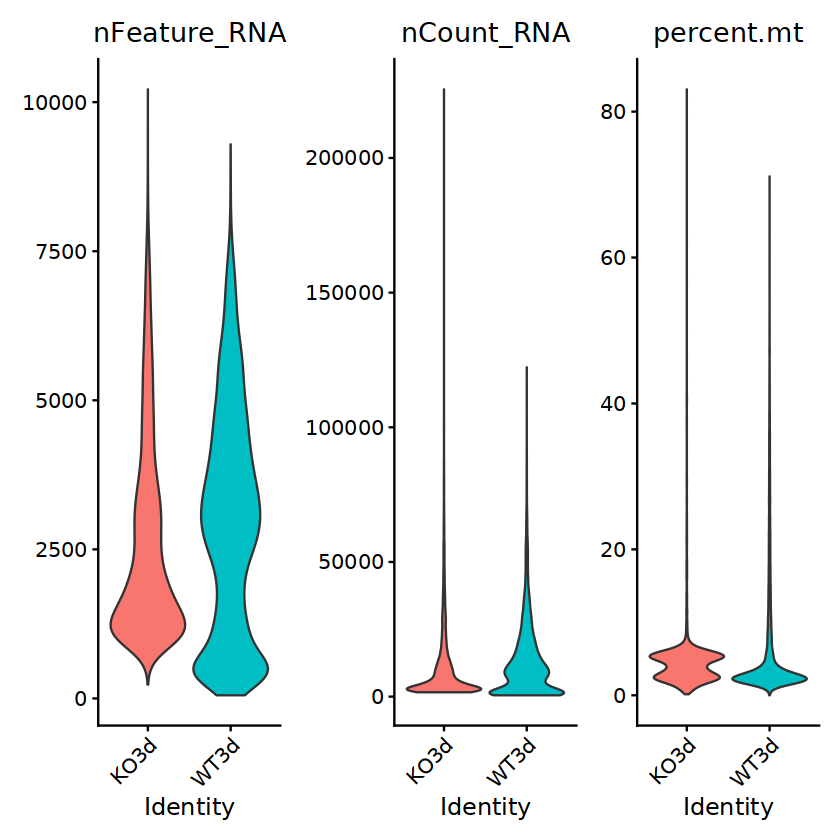

Saving 13 x 6.67 in image


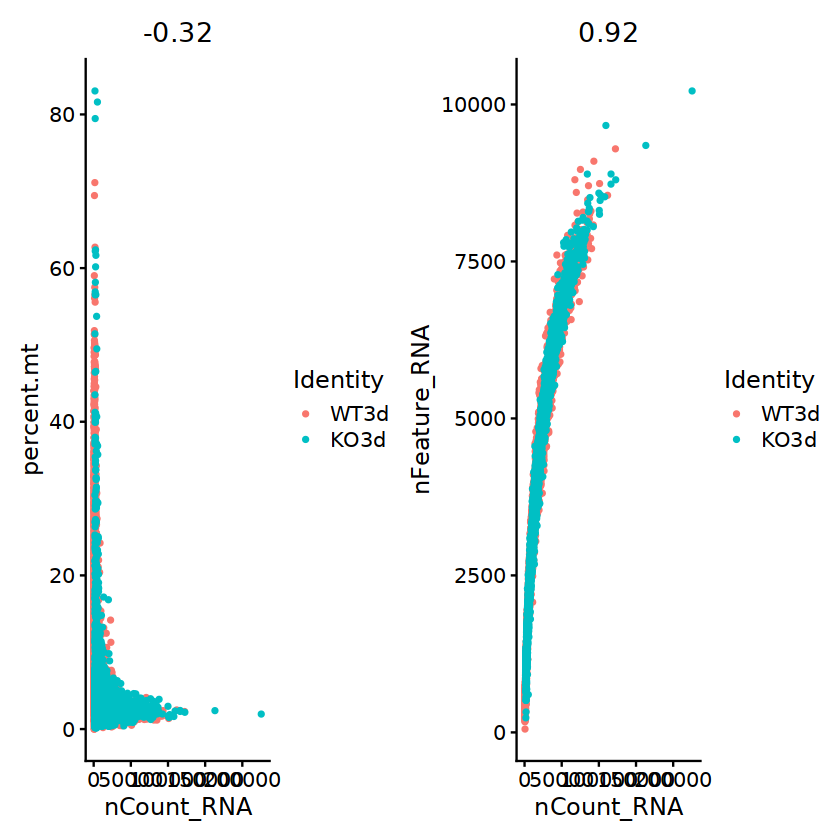

Warning message in system("timedatectl", intern = TRUE):
"running command 'timedatectl' had status 1"
-- Attaching packages --------------------------------------- tidyverse 1.3.2 --
v tibble  3.2.1     v dplyr   1.1.2
v tidyr   1.3.0     v stringr 1.5.0
v readr   2.1.4     v forcats 1.0.0
v purrr   1.0.1     
Warning message:
"package 'tibble' was built under R version 4.2.3"
Warning message:
"package 'tidyr' was built under R version 4.2.3"
Warning message:
"package 'readr' was built under R version 4.2.3"
Warning message:
"package 'purrr' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
Warning message:
"package 'stringr' was built under R version 4.2.3"
Warning message:
"package 'forcats' was built under R version 4.2.3"
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Warning message:
"package 'patchwork' was built under R 

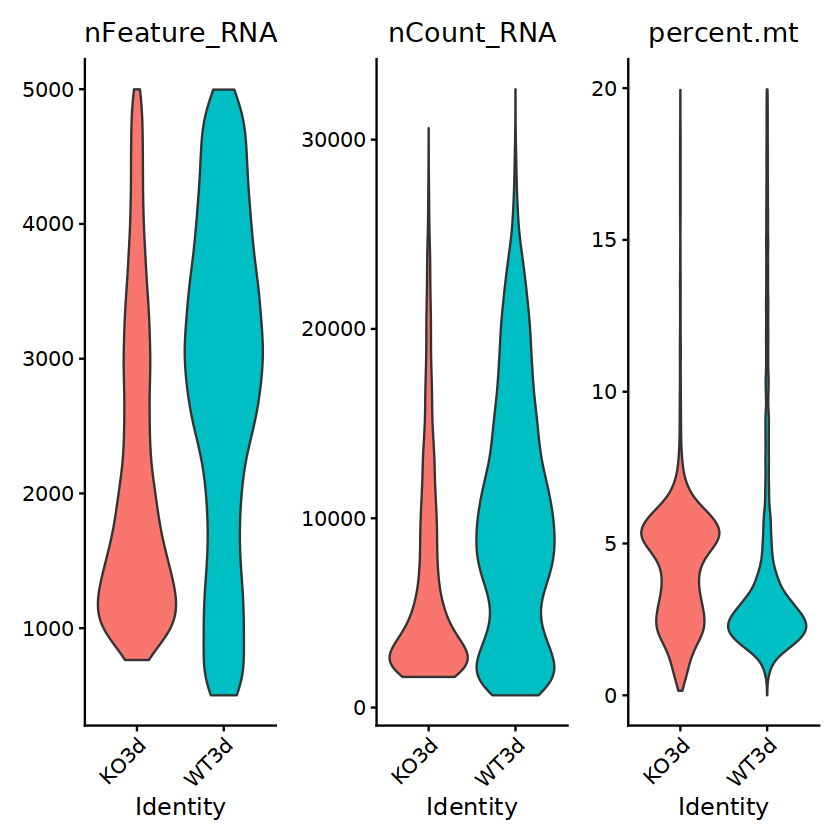

In [1]:
setwd('/import/DB/workdir/cd40/')

library(Seurat)

WT3d = Read10X_h5('./WT/CD_WT/outs/filtered_feature_bc_matrix.h5')

sc1 = CreateSeuratObject(WT3d,project = 'WT3d')

KO3d = Read10X_h5('./KO/CD_KO/filtered_feature_bc_matrix.h5')

sc2 = CreateSeuratObject(KO3d,project = 'KO3d')

single.ob=merge(sc1,sc2)

immune.combined = single.ob

immune.combined[["percent.mt"]] <- PercentageFeatureSet(immune.combined,pattern = "^mt-")

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

library(ggplot2)

ggsave('figure1.pdf',height =  4,width = 6)

Idents(immune.combined) = 'orig.ident'

plot1 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "percent.mt")
plot2 <- FeatureScatter(immune.combined, 
                        feature1 = "nCount_RNA", 
                        feature2 = "nFeature_RNA")
plot1 + plot2

ggsave('scatter.pdf',,width = 13)

immune.combined <-   subset(immune.combined, subset = nFeature_RNA > 500 & nFeature_RNA < 5000 & percent.mt < 20)

VlnPlot(immune.combined, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3,pt.size = 0,group.by="orig.ident")

ggsave('figure1-1.pdf',height =  4,width = 6)

library(DoubletFinder)
library(tidyverse)
library(Seurat)
library(patchwork)

In [2]:
immune.combined <-NormalizeData(immune.combined)
immune.combined <- ScaleData(immune.combined,feature=rownames(immune.combined), verbose = FALSE)
immune.combined <- FindVariableFeatures(object = immune.combined,selection.method = 'vst', nfeatures = 2000)
immune.combined <- RunPCA(immune.combined,  features = VariableFeatures(object = immune.combined) ,verbose = FALSE)
immune.combined <- RunUMAP(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- RunTSNE(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindNeighbors(immune.combined, reduction = "pca", dims = 1:20)
immune.combined <- FindClusters(immune.combined)

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"
01:39:03 UMAP embedding parameters a = 0.9922 b = 1.112

01:39:03 Read 14189 rows and found 20 numeric columns

01:39:03 Using Annoy for neighbor search, n_neighbors = 30

01:39:03 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:39:04 Writing NN index file to temp file /tmp/RtmphNVHOI/file8139c7360b8

01:39:04 Searching Annoy index using 1 thread, search_k = 3000

01:39:08 Annoy recall = 100%

01:39:08 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors =

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14189
Number of edges: 448388

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8436
Number of communities: 20
Elapsed time: 4 seconds


In [3]:
H9 = immune.combined

In [4]:
paramSweep = function (seu, PCs = 1:20, sct = FALSE, num.cores = 1) 
{
    require(Seurat)
    require(fields)
    require(parallel)
    pK <- c(5e-04, 0.001, 0.005, seq(0.01, 0.3, by = 0.01))
    pN <- seq(0.05, 0.3, by = 0.05)
    min.cells <- round(nrow(seu@meta.data)/(1 - 0.05) - nrow(seu@meta.data))
    pK.test <- round(pK * min.cells)
    pK <- pK[which(pK.test >= 1)]
    orig.commands <- seu@commands
    if (nrow(seu@meta.data) > 10000) {
        real.cells <- rownames(seu@meta.data)[sample(1:nrow(seu@meta.data), 
            10000, replace = FALSE)]
        data <- seu@assays$RNA@counts[, real.cells]
        n.real.cells <- ncol(data)
    }
    if (nrow(seu@meta.data) <= 10000) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts
        n.real.cells <- ncol(data)
    }
    if (num.cores > 1) {
        require(parallel)
        cl <- makeCluster(num.cores)
        output2 <- mclapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct, mc.cores = num.cores)
        stopCluster(cl)
    }
    else {
        output2 <- lapply(as.list(1:length(pN)), FUN = parallel_paramSweep, 
            n.real.cells, real.cells, pK, pN, data, orig.commands, 
            PCs, sct)
    }
    sweep.res.list <- list()
    list.ind <- 0
    for (i in 1:length(output2)) {
        for (j in 1:length(output2[[i]])) {
            list.ind <- list.ind + 1
            sweep.res.list[[list.ind]] <- output2[[i]][[j]]
        }
    }
    name.vec <- NULL
    for (j in 1:length(pN)) {
        name.vec <- c(name.vec, paste("pN", pN[j], "pK", pK, 
            sep = "_"))
    }
    names(sweep.res.list) <- name.vec
    return(sweep.res.list)
}

In [5]:
sweep.res.list_kidney <- paramSweep(H9, PCs = 1:20, sct = FALSE)

Loading required package: fields

Loading required package: spam

Spam version 2.10-0 (2023-10-23) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: 'spam'


The following objects are masked from 'package:base':

    backsolve, forwardsolve


Loading required package: viridisLite

Warning message:
"package 'viridisLite' was built under R version 4.2.3"

Try help(fields) to get started.

Loading required package: parallel



[1] "Creating artificial doublets for pN = 5%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 10%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 15%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 20%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 25%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."
[1] "Creating artificial doublets for pN = 30%"
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Defining neighborhoods..."
[1] "Computing pANN across all pK..."
[1] "pK = 0.001..."
[1] "pK = 0.005..."
[1] "pK = 0.01..."
[1] "pK = 0.02..."
[1] "pK = 0.03..."
[1] "pK = 0.04..."
[1] "pK = 0.05..."
[1] "pK = 0.06..."
[1] "pK = 0.07..."
[1] "pK = 0.08..."
[1] "pK = 0.09..."
[1] "pK = 0.1..."
[1] "pK = 0.11..."
[1] "pK = 0.12..."
[1] "pK = 0.13..."
[1] "pK = 0.14..."
[1] "pK = 0.15..."
[1] "pK = 0.16..."
[1] "pK = 0.17..."
[1] "pK = 0.18..."
[1] "pK = 0.19..."
[1] "pK = 0.2..."
[1] "pK = 0.21..."
[1] "pK = 0.22..."
[1] "pK = 0.23..."
[1] "pK = 0.24..."
[1] "pK = 0.25..."
[1] "pK = 0.26..."
[1] "pK = 0.27..."
[1] "pK = 0.28..."
[1] "pK = 0.29..."
[1] "pK = 0.3..."


Loading required package: KernSmooth

Warning message:
"package 'KernSmooth' was built under R version 4.2.3"
KernSmooth 2.23 loaded
Copyright M. P. Wand 1997-2009

Loading required package: ROCR

Warning message:
"package 'ROCR' was built under R version 4.2.3"


NULL


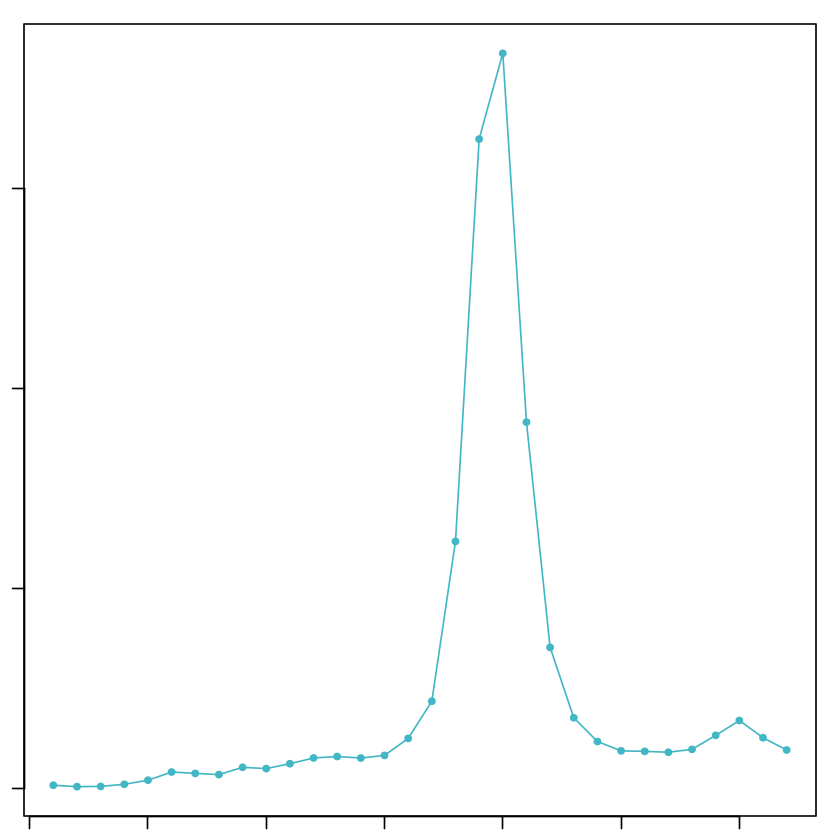

In [6]:
sweep.stats_kidney <- summarizeSweep(sweep.res.list_kidney, GT = FALSE)
bcmvn_kidney <- find.pK(sweep.stats_kidney)

In [7]:
pK_bcmvn <- bcmvn_kidney$pK[which.max(bcmvn_kidney$BCmetric)] %>% as.character() %>% as.numeric()

In [8]:
DoubletRate = ncol(H9)*8*1e-7

In [9]:
DoubletRate

[1] 0.0113512

In [10]:
homotypic.prop <- modelHomotypic(H9$orig.ident)

In [11]:
nExp_poi <- round(DoubletRate*ncol(H9)) 
nExp_poi.adj <- round(nExp_poi*(1-homotypic.prop))

In [12]:
doubletFinder = function (seu, PCs, pN = 0.25, pK, nExp, reuse.pANN = FALSE, 
    sct = FALSE, annotations = NULL) 
{
    require(Seurat)
    require(fields)
    require(KernSmooth)
    if (reuse.pANN != FALSE) {
        pANN.old <- seu@meta.data[, reuse.pANN]
        classifications <- rep("Singlet", length(pANN.old))
        classifications[order(pANN.old, decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        return(seu)
    }
    if (reuse.pANN == FALSE) {
        real.cells <- rownames(seu@meta.data)
        data <- seu@assays$RNA@counts[, real.cells]
        n_real.cells <- length(real.cells)
        n_doublets <- round(n_real.cells/(1 - pN) - n_real.cells)
        print(paste("Creating", n_doublets, "artificial doublets...", 
            sep = " "))
        real.cells1 <- sample(real.cells, n_doublets, replace = TRUE)
        real.cells2 <- sample(real.cells, n_doublets, replace = TRUE)
        doublets <- (data[, real.cells1] + data[, real.cells2])/2
        colnames(doublets) <- paste("X", 1:n_doublets, sep = "")
        data_wdoublets <- cbind(data, doublets)
        if (!is.null(annotations)) {
            stopifnot(typeof(annotations) == "character")
            stopifnot(length(annotations) == length(Cells(seu)))
            stopifnot(!any(is.na(annotations)))
            annotations <- factor(annotations)
            names(annotations) <- Cells(seu)
            doublet_types1 <- annotations[real.cells1]
            doublet_types2 <- annotations[real.cells2]
        }
        orig.commands <- seu@commands
        if (sct == FALSE) {
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Normalizing Seurat object...")
            seu_wdoublets <- NormalizeData(seu_wdoublets, normalization.method = orig.commands$NormalizeData.RNA@params$normalization.method, 
                scale.factor = orig.commands$NormalizeData.RNA@params$scale.factor, 
                margin = orig.commands$NormalizeData.RNA@params$margin)
            print("Finding variable genes...")
            seu_wdoublets <- FindVariableFeatures(seu_wdoublets, 
                selection.method = orig.commands$FindVariableFeatures.RNA$selection.method, 
                loess.span = orig.commands$FindVariableFeatures.RNA$loess.span, 
                clip.max = orig.commands$FindVariableFeatures.RNA$clip.max, 
                mean.function = orig.commands$FindVariableFeatures.RNA$mean.function, 
                dispersion.function = orig.commands$FindVariableFeatures.RNA$dispersion.function, 
                num.bin = orig.commands$FindVariableFeatures.RNA$num.bin, 
                binning.method = orig.commands$FindVariableFeatures.RNA$binning.method, 
                nfeatures = orig.commands$FindVariableFeatures.RNA$nfeatures, 
                mean.cutoff = orig.commands$FindVariableFeatures.RNA$mean.cutoff, 
                dispersion.cutoff = orig.commands$FindVariableFeatures.RNA$dispersion.cutoff)
            print("Scaling data...")
            seu_wdoublets <- ScaleData(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                model.use = orig.commands$ScaleData.RNA$model.use, 
                do.scale = orig.commands$ScaleData.RNA$do.scale, 
                do.center = orig.commands$ScaleData.RNA$do.center, 
                scale.max = orig.commands$ScaleData.RNA$scale.max, 
                block.size = orig.commands$ScaleData.RNA$block.size, 
                min.cells.to.block = orig.commands$ScaleData.RNA$min.cells.to.block)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, features = orig.commands$ScaleData.RNA$features, 
                npcs = length(PCs), rev.pca = orig.commands$RunPCA.RNA$rev.pca, 
                weight.by.var = orig.commands$RunPCA.RNA$weight.by.var, 
                verbose = FALSE)
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        if (sct == TRUE) {
            require(sctransform)
            print("Creating Seurat object...")
            seu_wdoublets <- CreateSeuratObject(counts = data_wdoublets)
            print("Running SCTransform...")
            seu_wdoublets <- SCTransform(seu_wdoublets)
            print("Running PCA...")
            seu_wdoublets <- RunPCA(seu_wdoublets, npcs = length(PCs))
            pca.coord <- seu_wdoublets@reductions$pca@cell.embeddings[, 
                PCs]
            cell.names <- rownames(seu_wdoublets@meta.data)
            nCells <- length(cell.names)
            rm(seu_wdoublets)
            gc()
        }
        print("Calculating PC distance matrix...")
        dist.mat <- fields::rdist(pca.coord)
        print("Computing pANN...")
        pANN <- as.data.frame(matrix(0L, nrow = n_real.cells, 
            ncol = 1))
        if (!is.null(annotations)) {
            neighbor_types <- as.data.frame(matrix(0L, nrow = n_real.cells, 
                ncol = length(levels(doublet_types1))))
        }
        rownames(pANN) <- real.cells
        colnames(pANN) <- "pANN"
        k <- round(nCells * pK)
        for (i in 1:n_real.cells) {
            neighbors <- order(dist.mat[, i])
            neighbors <- neighbors[2:(k + 1)]
            pANN$pANN[i] <- length(which(neighbors > n_real.cells))/k
            if (!is.null(annotations)) {
                for (ct in unique(annotations)) {
                  neighbors_that_are_doublets = neighbors[neighbors > 
                    n_real.cells]
                  if (length(neighbors_that_are_doublets) > 0) {
                    neighbor_types[i, ] <- table(doublet_types1[neighbors_that_are_doublets - 
                      n_real.cells]) + table(doublet_types2[neighbors_that_are_doublets - 
                      n_real.cells])
                    neighbor_types[i, ] <- neighbor_types[i, 
                      ]/sum(neighbor_types[i, ])
                  }
                  else {
                    neighbor_types[i, ] <- NA
                  }
                }
            }
        }
        print("Classifying doublets..")
        classifications <- rep("Singlet", n_real.cells)
        classifications[order(pANN$pANN[1:n_real.cells], decreasing = TRUE)[1:nExp]] <- "Doublet"
        seu@meta.data[, paste("pANN", pN, pK, nExp, sep = "_")] <- pANN[rownames(seu@meta.data), 
            1]
        seu@meta.data[, paste("DF.classifications", pN, pK, nExp, 
            sep = "_")] <- classifications
        if (!is.null(annotations)) {
            colnames(neighbor_types) = levels(doublet_types1)
            for (ct in levels(doublet_types1)) {
                seu@meta.data[, paste("DF.doublet.contributors", 
                  pN, pK, nExp, ct, sep = "_")] <- neighbor_types[, 
                  ct]
            }
        }
        return(seu)
    }
}

In [13]:
scRNA <- doubletFinder(H9, PCs = 1:20, pN = 0.25, pK = pK_bcmvn, 
                          nExp = nExp_poi.adj, reuse.pANN = F, sct = F)

[1] "Creating 4730 artificial doublets..."
[1] "Creating Seurat object..."
[1] "Normalizing Seurat object..."
[1] "Finding variable genes..."
[1] "Scaling data..."


Centering and scaling data matrix



[1] "Running PCA..."
[1] "Calculating PC distance matrix..."
[1] "Computing pANN..."
[1] "Classifying doublets.."


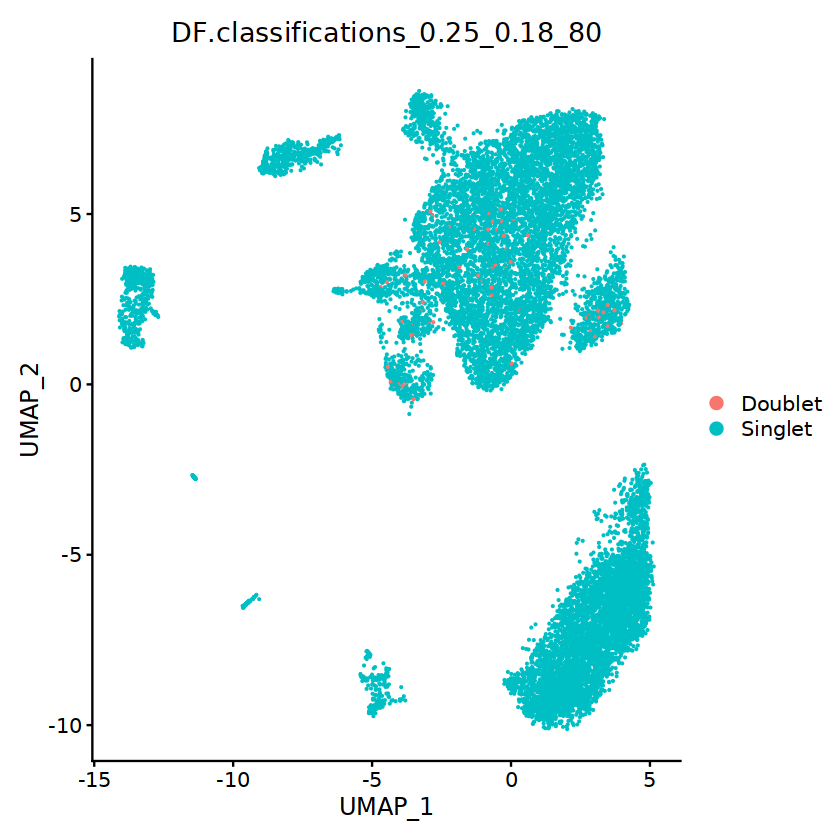

In [16]:
DimPlot(scRNA, reduction = "umap", group.by = "DF.classifications_0.25_0.18_80")

In [17]:
ggsave('figure2.pdf',height =  4,width = 5)

In [19]:
immune.combined = subset(scRNA, subset = DF.classifications_0.25_0.18_80  != 'Doublet')

In [20]:
table(immune.combined$orig.ident)


KO3d WT3d 
7004 7105 

In [21]:
ifnb.list <- SplitObject(immune.combined, split.by = "orig.ident")

testAB.anchors <- FindIntegrationAnchors(object.list = ifnb.list, dims = 1:20)
testAB.integrated <- IntegrateData(anchorset = testAB.anchors, dims = 1:20)

DefaultAssay(testAB.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
testAB.integrated <- ScaleData(testAB.integrated, features = rownames(testAB.integrated))
testAB.integrated <- RunPCA(testAB.integrated, npcs = 50, verbose = FALSE)
testAB.integrated <- FindNeighbors(testAB.integrated, dims = 1:30)
testAB.integrated <- FindClusters(testAB.integrated, resolution = 0.5)
testAB.integrated <- RunUMAP(testAB.integrated, dims = 1:30)
testAB.integrated <- RunTSNE(testAB.integrated, dims = 1:30)

immune.combined = testAB.integrated

Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 13386 anchors

Filtering anchors

	Retained 6217 anchors

Merging dataset 2 into 1

Extracting anchors for merged samples

Finding integration vectors

Finding integration vector weights

Integrating data

Centering and scaling data matrix

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 14109
Number of edges: 494626

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8825
Number of communities: 17
Elapsed time: 4 seconds


01:50:35 UMAP embedding parameters a = 0.9922 b = 1.112

01:50:35 Read 14109 rows and found 30 numeric columns

01:50:35 Using Annoy for neighbor search, n_neighbors = 30

01:50:35 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

01:50:37 Writing NN index file to temp file /tmp/RtmphNVHOI/file81394f71b668

01:50:37 Searching Annoy index using 1 thread, search_k = 3000

01:50:40 Annoy recall = 100%

01:50:41 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 30

01:50:42 Found 2 connected components, 
falling back to 'spca' initialization with init_sdev = 1

01:50:42 Using 'irlba' for PCA

01:50:42 PCA: 2 components explained 46.01% variance

01:50:42 Scaling init to sdev = 1

01:50:42 Commencing optimization for 200 epochs, with 614676 

In [22]:
saveRDS(immune.combined,file = 'before_rename.rds')

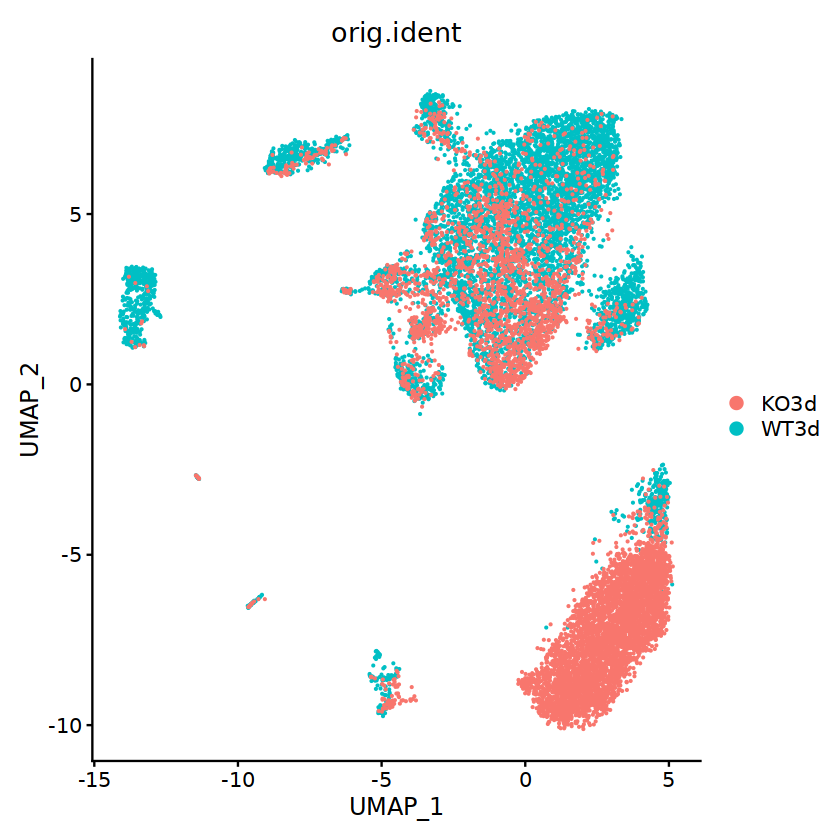

In [23]:
DimPlot(scRNA, reduction = "umap", group.by = "orig.ident")

In [24]:
ggsave('figure3.pdf',height =  4,width = 5)

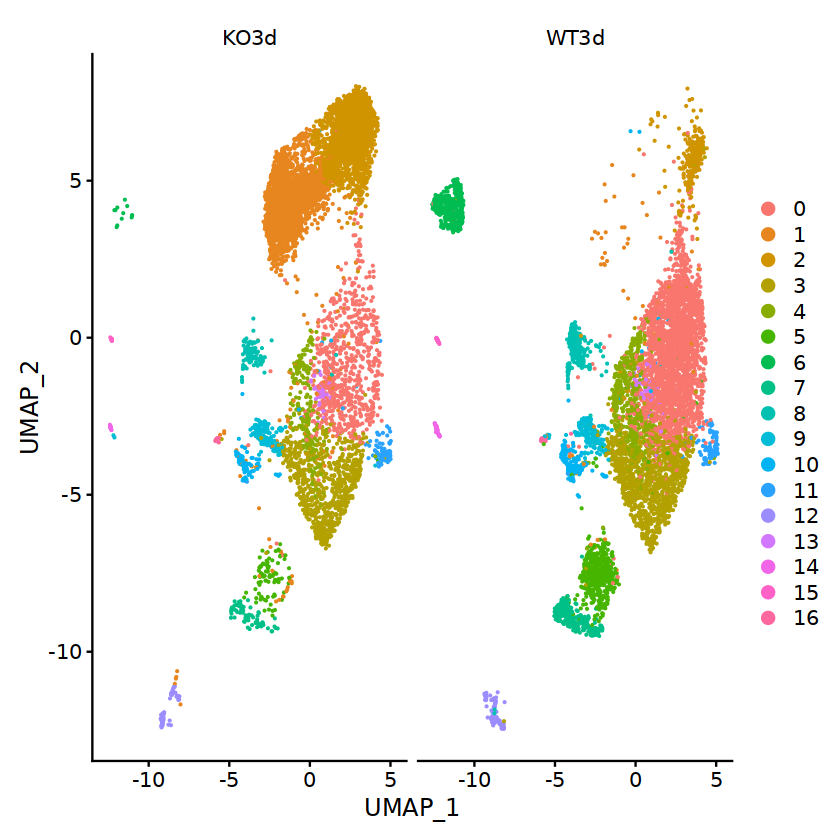

In [25]:
DimPlot(immune.combined, reduction = "umap", split.by  = "orig.ident",ncol = 2)

In [26]:
ggsave('figure4.pdf',height =  8,width = 12)

In [27]:
scRNA = immune.combined

In [30]:
library(Seurat) ##
library(SingleR)
library(ggplot2)
library(reshape2)
mouseImmu  = get(load('/import/DB/SingleR_ref/ref_Mouse_all.RData'))
pbmc_for_SingleR <- GetAssayData(scRNA, slot="data") ##获取标准化矩阵
clusters=scRNA@meta.data$seurat_clusters
pred.mouseImmu <- SingleR(test = pbmc_for_SingleR, ref = mouseImmu, labels = mouseImmu$label.main,
 method = "cluster", clusters = clusters, 
 assay.type.test = "logcounts", assay.type.ref = "logcounts")
celltype = data.frame(ClusterID=rownames(pred.mouseImmu), celltype=pred.mouseImmu$labels, stringsAsFactors = FALSE)

Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = TRUE."
Warning message:
"useNames =

In [31]:
scRNA@meta.data$celltype = "NA"
# 赋值
for(i in 1:nrow(celltype)){
  scRNA@meta.data[which(scRNA@meta.data$seurat_clusters == celltype$ClusterID[i]),'celltype'] <- celltype$celltype[i]}

In [32]:
#scRNA = readRDS('./after_rename.rds')

Warning message in gzfile(file, "rb"):
"cannot open compressed file './after_rename.rds', probable reason 'No such file or directory'"


ERROR: Error in gzfile(file, "rb"): cannot open the connection


In [34]:
scRNA

An object of class Seurat 
34285 features across 14109 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, umap, tsne

In [35]:
library(Seurat)

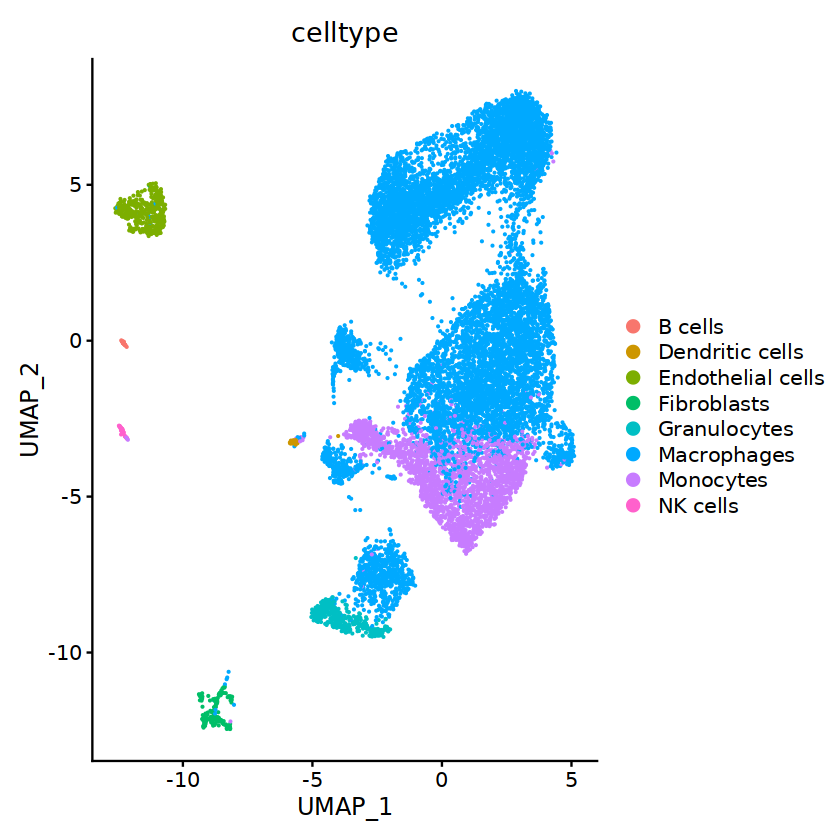

In [36]:
DimPlot(scRNA, group.by="celltype", label=F, label.size=5, reduction='umap')

In [37]:
library(ggplot2)

In [ ]:
ggsave('figure5.pdf',height =  8,width = 9)

In [ ]:
DimPlot(scRNA, group.by="seurat_clusters", label=T, label.size=5, reduction='umap')

In [ ]:
ggsave('figure6.pdf',height =  8,width = 9)

In [ ]:
table(scRNA$seurat_clusters)

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
scedata = scRNA

In [ ]:
Idents(scRNA) = 'seurat_clusters'

In [ ]:
DotPlot(scRNA,features = c('Plac8','Chil3','Ly6c2'))


 KO3d  KO7d  MI3d  MI7d 
 5615  9251 11199 14819 


        Monocytes      Granulocytes           T cells       Fibroblasts 
      0.250317973       0.065624694       0.084336171       0.351922512 
      Macrophages           B cells Endothelial cells          NK cells 
      0.102387242       0.060243616       0.039208492       0.037080520 
  Dendritic cells 
      0.008878779 

                   
                    KO3d KO7d MI3d MI7d
  Monocytes         1839 1642 4547 2206
  Granulocytes      1544  271  578  290
  T cells            829  954  564 1101
  Fibroblasts        272 4026 2282 7808
  Macrophages        662  863 1902  759
  B cells            177  592  740  954
  Endothelial cells   53  429  346  775
  NK cells           134  375  164  843
  Dendritic cells    105   99   76   83

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“package ‘dplyr’ was built under R version 4.2.3”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggalluvial’ was built under R version 4.2.3”


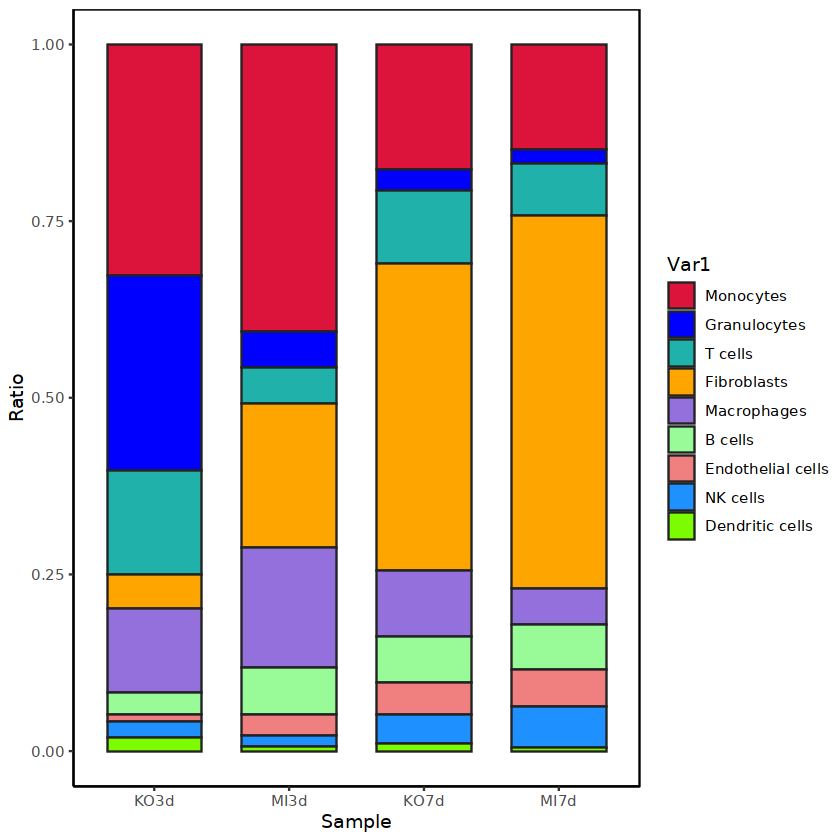

In [20]:
Idents(scRNA) ='celltype'

scedata = scRNA
table(scedata$orig.ident)#查看各组细胞数
prop.table(table(Idents(scedata)))
table(Idents(scedata), scedata$orig.ident)#各组不同细胞群细胞数
Cellratio <- prop.table(table(Idents(scedata), scedata$orig.ident), margin = 2)#计算各组样本不同细胞群比例
Cellratio <- as.data.frame(Cellratio)

Cellratio$Var2 = factor(Cellratio$Var2,levels = c('KO3d',  'MI3d', 'KO7d', 'MI7d'))

allcolour=c("#DC143C","#0000FF","#20B2AA","#FFA500","#9370DB","#98FB98","#F08080","#1E90FF","#7CFC00","#FFFF00",
            "#808000","#FF00FF","#FA8072","#7B68EE","#9400D3","#800080","#A0522D","#D2B48C","#D2691E","#87CEEB","#40E0D0","#5F9EA0",
            "#FF1493","#0000CD","#008B8B","#FFE4B5","#8A2BE2","#228B22","#E9967A","#4682B4","#32CD32","#F0E68C","#FFFFE0","#EE82EE",
            "#FF6347","#6A5ACD","#9932CC","#8B008B","#8B4513","#DEB887")
library(ggplot2)
ggplot(Cellratio) + 
  geom_bar(aes(x =Var2, y= Freq, fill = Var1),stat = "identity",width = 0.7,size = 0.5,colour = '#222222')+ 
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour)+
  theme(panel.border = element_rect(fill=NA,color="black", size=0.5, linetype="solid"))

library(Seurat)
library(ggplot2)
library(dplyr)
library(ggalluvial)

In [112]:
saveRDS(scRNA,file = 'after_rename.rds')

## 往下都是没有运行的

In [102]:
options(repr.plot.height = 6,rpr.plot.wdith = 5)

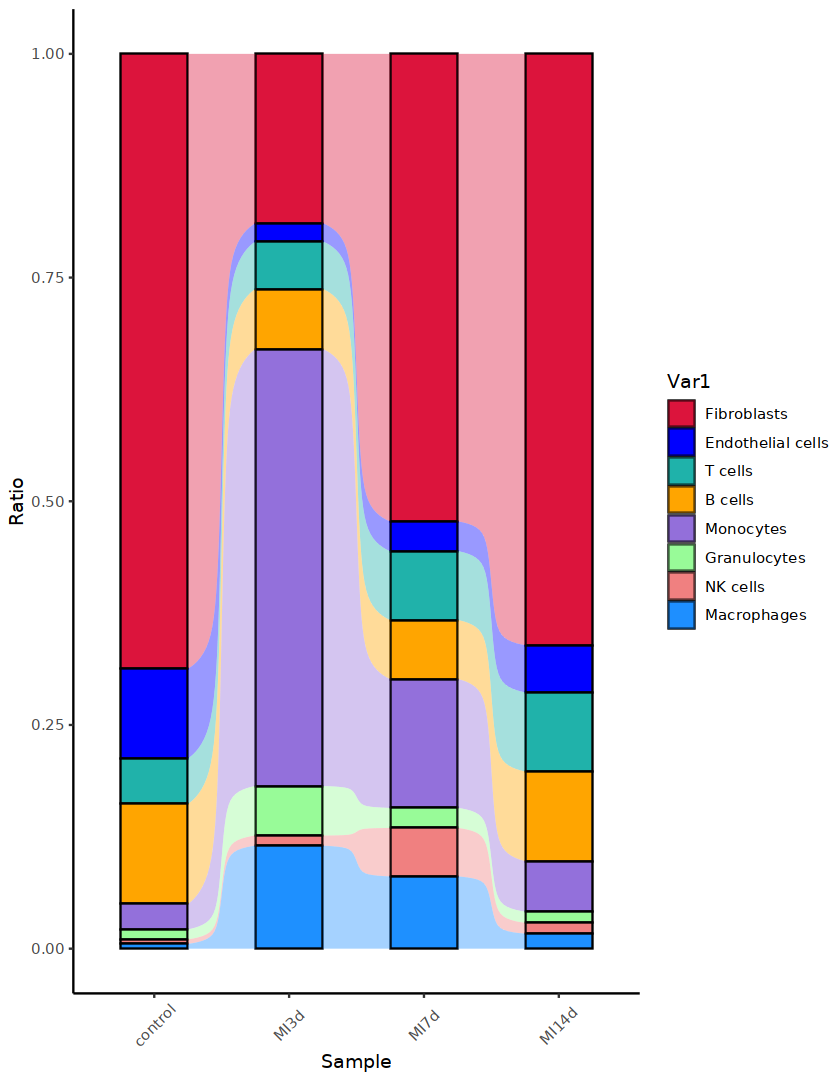

In [227]:
ggplot(Cellratio, aes(x =Var2, y= Freq, fill = Var1,
                  stratum=Var1, alluvium=Var1)) +
  geom_col(width = 0.5, color='black')+
  geom_flow(width=0.5,alpha=0.4, knot.pos=0.5)+ # 参数knot.pos设置为0.5使连接为曲线面积，就像常见的桑基图
  theme_classic() +
  labs(x='Sample',y = 'Ratio')+
  scale_fill_manual(values = allcolour) + theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

In [228]:
ggsave('figure6.pdf',height =  5,width = 4)

In [5]:
scRNA  = readRDS('./after_rename.rds')

In [6]:
Idents(scRNA) = 'seurat_clusters'

In [7]:
Idents(scRNA) = 'celltype'

sce.markers <- FindAllMarkers(object = scRNA, only.pos = TRUE, 
                              min.pct = 0.25, 
                              thresh.use = 0.25)
 

library(dplyr) 
# 不同seurat版本的 avg_logFC 不一样 
top5 <- sce.markers %>% group_by(cluster) %>% top_n(5, avg_log2FC)



### https://zhuanlan.zhihu.com/p/573321126
## https://zhuanlan.zhihu.com/p/594345612


Calculating cluster Monocytes

Calculating cluster Granulocytes

Calculating cluster T cells

Calculating cluster Fibroblasts

Calculating cluster Macrophages

Calculating cluster B cells

Calculating cluster Endothelial cells

Calculating cluster NK cells

Calculating cluster Dendritic cells

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [9]:
# options(repr.plot.height = 9,repr.plot.width = 7)

#  DotPlot(scRNA, features = unique(top5$gene) ,
#  assay='RNA' ) + coord_flip()+ theme(axis.text.x = element_text(angle = 45, 
#  vjust = 0.5, hjust=0.5))

In [ ]:
ggsave('figure7.pdf',height =  9,width = 8)

In [10]:
library('clusterProfiler')



Registered S3 methods overwritten by 'treeio':
  method              from    
  MRCA.phylo          tidytree
  MRCA.treedata       tidytree
  Nnode.treedata      tidytree
  Ntip.treedata       tidytree
  ancestor.phylo      tidytree
  ancestor.treedata   tidytree
  child.phylo         tidytree
  child.treedata      tidytree
  full_join.phylo     tidytree
  full_join.treedata  tidytree
  groupClade.phylo    tidytree
  groupClade.treedata tidytree
  groupOTU.phylo      tidytree
  groupOTU.treedata   tidytree
  is.rooted.treedata  tidytree
  nodeid.phylo        tidytree
  nodeid.treedata     tidytree
  nodelab.phylo       tidytree
  nodelab.treedata    tidytree
  offspring.phylo     tidytree
  offspring.treedata  tidytree
  parent.phylo        tidytree
  parent.treedata     tidytree
  root.treedata       tidytree
  rootnode.phylo      tidytree
  sibling.phylo       tidytree

clusterProfiler v4.6.2  For help: https://yulab-smu.top/biomedical-knowledge-mining-book/

If you use clusterProf

In [11]:
library(dplyr) 
top50 <- sce.markers %>% group_by(cluster) %>% top_n(50, avg_log2FC)

group <- data.frame(gene=top50$gene,
                    group=top50$cluster)

Gene_ID <- bitr(top50$gene, fromType="SYMBOL", 
            toType="ENTREZID", 
            OrgDb="org.Mm.eg.db")
data  <- merge(Gene_ID,group,by.x='SYMBOL',by.y='gene')
data_GO <- compareCluster(
  ENTREZID~group, 
  data=data, 
  fun="enrichGO", 
  OrgDb="org.Mm.eg.db",
  ont = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff = 0.05,
  qvalueCutoff = 0.05,
  readable = TRUE
)





'select()' returned 1:1 mapping between keys and columns

Warning message in bitr(top50$gene, fromType = "SYMBOL", toType = "ENTREZID", OrgDb = "org.Mm.eg.db"):
"2.93% of input gene IDs are fail to map..."


In [21]:
top50

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0,2.524560,0.946,0.676,0,Monocytes,H2-Ab1
0,2.352975,0.880,0.439,0,Monocytes,Ms4a4c
0,2.336550,0.876,0.703,0,Monocytes,Plac8
0,2.302972,0.936,0.590,0,Monocytes,H2-Aa
0,2.282660,0.931,0.600,0,Monocytes,H2-Eb1
0,2.272464,0.915,0.372,0,Monocytes,Ms4a6c
0,2.256347,0.976,0.730,0,Monocytes,Cd74
0,2.184324,0.935,0.664,0,Monocytes,S100a4
0,2.162664,0.949,0.695,0,Monocytes,Lyz2


In [12]:
data_GO_sim <- simplify(data_GO, 
                        cutoff=0.5, 
                        by="p.adjust", 
                        select_fun=min)

write.csv(data_GO_sim@compareClusterResult,file = 'enrichment.csv',row.names =F)

In [13]:
options(repr.plot.height = 9,repr.plot.width = 7)
enrichplot::dotplot(data_GO_sim, showCategory=4,font.size = 8)+ theme(axis.text.x = element_text(angle = 45, 
 vjust = 0.5, hjust=0.5))

ERROR: Error in theme(axis.text.x = element_text(angle = 45, vjust = 0.5, hjust = 0.5)): could not find function "theme"


In [242]:
ggsave('figure8.pdf',height =  9,width = 8)

In [163]:
saveRDS(scRNA ,file = 'after_rename.rds')